x_train (10000, 2)
y_train (10000, 1)
Coefficient:  [[2.00191917 0.97693507]]
Intercept:  [-0.08632169]
x_test (5000, 2)
y_test (5000, 1)
R^2 score on test data:  0.1428101580403489
[bnlearn] >Bayesian DAG created.
[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel


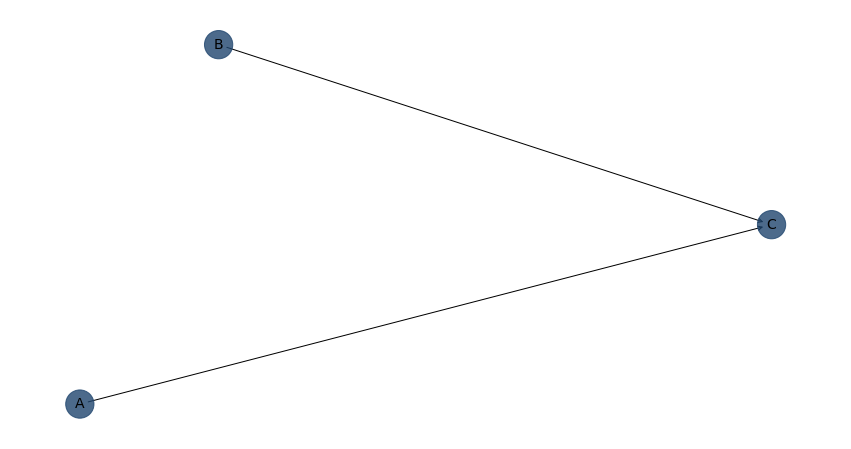

[bnlearn] >No CPDs to print. Tip: use bnlearn.plot(DAG) to make a plot.
target      A      C      B
source                     
A       False   True  False
C       False  False  False
B       False   True  False
<class 'pandas.core.frame.DataFrame'>
[bnlearn] >Forward sampling for 100 samples..


Exception: [bnlearn] >Error! This is a Bayesian DAG containing only edges, and no CPDs. Tip: you need to specify or learn the CPDs. Try: DAG=bn.parameter_learning.fit(DAG, df). At this point you can make a plot with: bn.plot(DAG).

In [1]:

import bnlearn
from notears.linear import notears_linear
from sklearn.linear_model import LinearRegression as LinReg
from dagsim.baseDS import Graph, Generic
from notears import utils
import pandas as pd
import numpy as np
import bnlearn as bn

# Definition of Rule or Ground truth to be learned by the program
def linear_transformation(params0, params1):
    y = 2 * params0 + params1 + 5 * params0 * params1
    #1 model with 4 x binary, with binary y with logistic regression
    #rank random forest, linear regression
    #Hot code categorical examples
    #1 - 0-10
    #2 - 10-25
    return y

# Setup procedure for the DAG setup - no interaction
def setup_dag():
    Prior1 = Generic(name="A", function=np.random.normal)
    Prior2 = Generic(name="B", function=np.random.normal)
    Node1 = Generic(name="C", function=linear_transformation, arguments={"params0": Prior1, "params1": Prior2})

    listNodes = [Prior1, Prior2, Node1]
    my_graph = Graph("Linear Regression - Real-world", listNodes)

    # simulate data for training and testing, with study-specific sample sizes
    train = my_graph.simulate(num_samples=10000, csv_name="train")
    test = my_graph.simulate(num_samples=5000, csv_name="test")

setup_dag()

# import the saved training data and load it into a numpy array
train_data = pd.read_csv("train.csv")
x_train = train_data.iloc[:, 0:2].to_numpy().reshape([-1, 2])
print("x_train", x_train.shape)
y_train = train_data.iloc[:, 2].to_numpy().reshape([-1, 1])
print("y_train", y_train.shape)

# Sklearn - Construct linear regression model and fit using simulated training data
def model_training(x_train, y_train):
    LR = LinReg()
    reg = LR.fit(x_train, y_train)
    reg.score(x_train, y_train)
    print("Coefficient: ", LR.coef_)
    print("Intercept: ", LR.intercept_)

    # import the saved testing data
    test_data = pd.read_csv("test.csv")
    x_test = test_data.iloc[:, 0:2].to_numpy().reshape([-1, 2])
    print("x_test", x_test.shape)
    y_test = test_data.iloc[:, 2].to_numpy().reshape([-1, 1])
    print("y_test", y_test.shape)

    y_pred = reg.predict(x_test)

    # Return the evaluation score (R^2) of the model on the testing data
    print("R^2 score on test data: ", LR.score(x_test, y_test))

model_training(x_train, y_train)

#print(x_train)
#Delete column row
#print(train_data.head)

train_data_numpy = train_data.to_numpy()

# Bnlearn simulation sampling
edges = [('A', 'C'),
         ('B', 'C')]
DAG = bnlearn.make_DAG(edges)
bn.plot(DAG)
print(DAG['adjmat'])
print(type(train_data))
DAG = bn.parameter_learning.fit(DAG, train_data, methodtype='maximumlikelihood')

bn.print_CPD(DAG)
bn_sample = bn.sampling(DAG, n=100)
print(bn_sample)
# NO TEARS simulation sampling
W_est = notears_linear(train_data_numpy[0:100, 0:3], lambda1=0.1, loss_type='l2')
assert utils.is_dag(W_est)
np.savetxt('W_est.csv', W_est, delimiter=',')